In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
sectors=["S1","S2","S3","S4"]
Evap_Sectors=pd.DataFrame(data=np.nan,columns=["mean","std"],index=sectors)
Evap_Sectors["mean"]=[0.002438,0.00275,-0.015,-0.0038]
Evap_Sectors["std"]=[0.006509,0.005,0.0083,0.0101]

warm_sonde_values={}

warm_sonde_values["RF05_AR_entire_1"]={
  'mass_div': -0.41276886889204784,
  'mass_div_min': -0.7301260286358718,
  'mass_div_max': -0.09541170914822367,
  'q_ADV': -0.7907497132061316,
  'q_ADV_min': -1.565287488594897,
  'q_ADV_max': -0.016211937817365973}

warm_sonde_values["RF05_AR_entire_2"]={
    'mass_div': -0.1882352622233449,
    'mass_div_min': -0.6452538732851526,
    'mass_div_max': 0.2687833488384628,
    'q_ADV': -0.5474630545351018,
    'q_ADV_min': -1.3557554102823333,
    'q_ADV_max': 0.2608293012121298}

warm_sonde_values["RF06_AR_entire_1"]={
    'mass_div': -0.23570411496183644,
    'mass_div_min': -0.602622062208785,
    'mass_div_max': 0.13121383228511205,
    'q_ADV': -0.7594541149453358,
    'q_ADV_min': -1.497718568202485,
    'q_ADV_max': -0.021189661688186773}

warm_sonde_values["RF06_AR_entire_2"]={
    'mass_div': -0.41276886889204784,
    'mass_div_min': -0.7301260286358718,
    'mass_div_max': -0.09541170914822367,
    'q_ADV': -0.7907497132061316,
    'q_ADV_min': -1.565287488594897,
    'q_ADV_max': -0.016211937817365973}

d_IWV_dt_sonde=pd.Series(data=[-0.25,-0.34,0.05,np.nan],index=["S1","S2","S3","S4"]) 
d_IWV_dt_hamp=pd.Series(data=[-0.49,-0.31,0.66,np.nan],index=["S1","S2","S3","S4"]) 
# third hamp value shifted due to not working F-BAND module

flights=["RF05","RF06"]
ars_of_day=["AR_entire_1","AR_entire_2"]

In [4]:
campaign="HALO_AC3"
halo_icon_hmps={}
halo_icon_ivts={}
precip_rates={}
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
s=0
for flight in flights:
    for ar_of_day in ars_of_day:
        sector_to_plot="warm"
        from simplified_flight_leg_handling import simplified_run_grid_main
        with HiddenPrints():
            halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
            simplified_run_grid_main(flight=[flight],config_file_path=major_work_path,ar_of_day=ar_of_day)
        # ICON File
        icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
        hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
        icon_resolution=2000 # units m
        upsample_time="20min"
        date=flight_dates[flight]
        interp_icon_hmp_file=flight+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
        interp_icon_ivt_file=flight+"_"+ar_of_day+"_"+"ICON_Interpolated_IVT.csv"
        icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,[flight],ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

        ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
        cmpgn_cls,icon_var_list,halo_df,[flight],date,
        interpolated_hmp_file=interp_icon_hmp_file,
        interpolated_hmc_file=None,ar_of_day=ar_of_day,
        upsample_time=upsample_time,
        synthetic_icon=False,
        synthetic_flight=False)

        hydrometeor_icon_path=hydrometeor_icon_path+flight+"/"
        ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
        halo_icon_ivts[flight+"_"+ar_of_day]=pd.read_csv(hydrometeor_icon_path+interp_icon_ivt_file,index_col=0)
        halo_icon_ivts[flight+"_"+ar_of_day]["Sector"]=sectors[s]
        halo_icon_hmps[flight+"_"+ar_of_day]=ICON_on_HALO.load_interpolated_hmp()
        halo_icon_hmps[flight+"_"+ar_of_day]["Sector"]=sectors[s]
        # read precip rates########
        rate_path =cmpgn_cls.campaign_path+"/data/precip_rates/"
        rate_fname=sector_to_plot+"_precip_"+flight+"_"+ar_of_day+".csv"
        precip_rates[flight+"_"+ar_of_day]=pd.read_csv(rate_path+rate_fname)
        ############
        s+=1
merged_rates        =pd.concat(precip_rates.values())
merged_halo_icon_hmp=pd.concat(halo_icon_hmps.values())
merged_halo_icon_ivt=pd.concat(halo_icon_ivts.values())

RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened
RF06_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


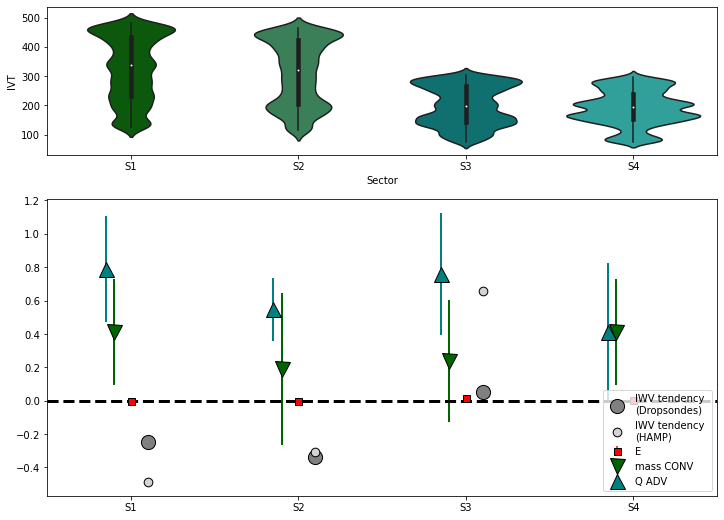

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
budget_components_fig, (ax1, ax2) =plt.subplots(2,1,figsize=(12,9),gridspec_kw={'height_ratios': [0.5, 1]})
sns.violinplot(data=merged_halo_icon_ivt, x="Sector", y="IVT",ax=ax1,palette=["darkgreen","seagreen","teal","lightseagreen"])
# Evaporation
ax2.errorbar([1,2,3,4], -1*Evap_Sectors["mean"].values, yerr=Evap_Sectors["std"].values, marker='s', mfc='red',
         mec='black', ecolor="r",ms=7, mew=1,ls="",label="E")
#Mass Convergence
ax2.errorbar(np.array([1,2,3,4])-0.1,-1*np.array([-0.41276886889204784,-0.1882352622233449,-0.23570411496183644,-0.41276886889204784]),
            yerr=[(-0.09541170914822367--0.7301260286358718)/2,
                  (0.2687833488384628--0.6452538732851526)/2,
                  (0.13121383228511205--0.602622062208785)/2,
                  (-0.09541170914822367--0.7301260286358718)/2],
            marker="v",ms=15,markeredgecolor="k",mfc="darkgreen",elinewidth=2,ecolor="darkgreen",ls="",label="mass CONV")
#Q ADV
ax2.errorbar(np.array([1,2,3,4])-0.15,
             -1*np.array([-0.7907497132061316,-0.5474630545351018,-0.7594541149453358,-0.41276886889204784]),
            yerr=[(-0.7301260286358718--0.09541170914822367)/2,
                  (-0.6452538732851526--0.2687833488384628)/2,
                  (-0.602622062208785-0.13121383228511205)/2,
                  (-0.7301260286358718-0.09541170914822367)/2],
            marker="^",ms=15,markeredgecolor="k",mfc="teal",elinewidth=2,ecolor="teal",ls="",label="Q ADV")
#IWV tendency
ax2.scatter(np.array([1,2,3])+0.1,np.array([-0.25,-0.34,0.05]),
            marker="o",s=200,edgecolor="k",facecolor="grey",label="IWV tendency \n(Dropsondes)")
ax2.scatter(np.array([1,2,3])+0.1,np.array([-0.49,-0.31,0.66]),
            marker="o",s=75,edgecolor="k",facecolor="lightgrey",label="IWV tendency \n(HAMP)")
#
ax2.axhline(y=0,ls="--",lw=3,color="k")
ax2.set_xlim([0.5,4.5])
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels(["S1","S2","S3","S4"])
ax2.legend(loc="lower right")